In [5]:
pip install git+https://github.com/dr-aheydari/SoftAdapt.git


  Cloning https://github.com/dr-aheydari/SoftAdapt.git to /tmp/pip-req-build-2kef3pit
  Running command git clone --filter=blob:none --quiet https://github.com/dr-aheydari/SoftAdapt.git /tmp/pip-req-build-2kef3pit
  Resolved https://github.com/dr-aheydari/SoftAdapt.git to commit 66e7bd6e300cad9b41a9edfd81c0d2b265a1504e
  Preparing metadata (setup.py) ... done


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 39.3 MB/s eta 0:00:00


In [6]:

#network

class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()

        # Neural network architecture
        self.layers = nn.ModuleList()
        for i in range(len(layers)-1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))
            if i < len(layers)-2:
                self.layers.append(nn.ReLU())

    def forward(self, theta_1,theta_2,theta_1_dot,theta_2_dot, t):
        # Concatenate spatial and temporal inputs
        inputs = torch.cat([theta_1,theta_2,theta_1_dot,theta_2_dot, t], dim=1)
        for layer in self.layers:
            inputs = layer(inputs)
        return inputs


In [7]:


# Define the neural network
"""class PiNN(nn.Module):
    def __init__(self):
        super(PiNN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(3, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 2)  # Output: theta1, theta2
        )

    def forward(self, t, theta1_0, theta2_0):
        # Input to the network: [t, theta1_0, theta2_0]
        input_data = torch.cat([t, theta1_0, theta2_0], dim=1)
        return self.network(input_data)
"""
# Physics-Informed Loss Function
#def pinn_loss(model, t, theta1_0, theta2_0, m1, m2, L1, L2, g):# theta1_dot_0, theta2_dot_0,
def loss_lagrange(model, t, theta1_0, theta2_0,theta1_dot_0, theta2_dot_0,weightss, smallval=10**(-9)):
    # Constants
    m1, m2 = 1.0, 1.0  # masses
    L1, L2 = 1.0, 1.0  # lengths
    g = -9.81           # gravity

    t=t.requires_grad_(True)
    # Predict theta1 and theta2
    theta_pred = model(theta1_0, theta2_0,theta1_dot_0, theta2_dot_0,t)
    theta1 = theta_pred[:, 0:1]
    theta2 = theta_pred[:, 1:2]
    theta1=theta1.requires_grad_(True)
    theta2=theta2.requires_grad_(True)

    # Compute derivatives using autograd
    theta1_dot = torch.autograd.grad(theta1, t, grad_outputs=torch.ones_like(theta1), create_graph=True)[0]
    theta2_dot = torch.autograd.grad(theta2, t, grad_outputs=torch.ones_like(theta2), create_graph=True)[0]

    theta1_ddot = torch.autograd.grad(theta1_dot, t, grad_outputs=torch.ones_like(theta1_dot), create_graph=True)[0]
    theta2_ddot = torch.autograd.grad(theta2_dot, t, grad_outputs=torch.ones_like(theta2_dot), create_graph=True)[0]

    # Residuals for the double pendulum equations

    E_kin=0.5*m1*(L1*theta1_dot)**2+0.5*m2*((L1**2)*(theta1_dot**2)+(L2**2)*(theta2_dot**2)+2*L1*L2*theta1_dot*theta2_dot*torch.cos(theta2-theta1))
    E_pot=m1*g*L1*(1-torch.cos(theta1))+m2*g*(L1*(1-torch.cos(theta1))+L2*(1-torch.cos(theta2)))

    Lagrange=E_kin-E_pot

    Lagrange_dtheta1=torch.autograd.grad(Lagrange,theta1 , grad_outputs=torch.ones_like(Lagrange), create_graph=True)[0]
    Lagrange_dtheta2=torch.autograd.grad(Lagrange,theta2 , grad_outputs=torch.ones_like(Lagrange), create_graph=True)[0]

    Lagrange_dtheta1_dot=torch.autograd.grad(Lagrange,theta1_dot , grad_outputs=torch.ones_like(Lagrange), create_graph=True)[0]
    Lagrange_dtheta2_dot=torch.autograd.grad(Lagrange,theta2_dot , grad_outputs=torch.ones_like(Lagrange), create_graph=True)[0]

    Lagrange_dtheta1_dot_dt=torch.autograd.grad(Lagrange_dtheta1_dot,t, grad_outputs=torch.ones_like(Lagrange_dtheta1_dot), create_graph=True)[0]
    Lagrange_dtheta2_dot_dt=torch.autograd.grad(Lagrange_dtheta2_dot,t, grad_outputs=torch.ones_like(Lagrange_dtheta2_dot), create_graph=True)[0]


    res_theta1 = Lagrange_dtheta1_dot_dt-Lagrange_dtheta1

    res_theta2 = Lagrange_dtheta2_dot_dt-Lagrange_dtheta2

    loss = (
        torch.mean(weightss*res_theta1**2) +
        torch.mean(weightss*res_theta2**2)
        )
    return loss

def loss_energy(model, t, theta1_0, theta2_0,theta1_dot_0, theta2_dot_0,weightss,smallval=10**(-9)):
    # Constants
    m1, m2 = 1.0, 1.0  # masses
    L1, L2 = 1.0, 1.0  # lengths
    g = -9.81           # gravity

    t=t.requires_grad_(True)
    # Predict theta1 and theta2
    theta_pred = model( theta1_0, theta2_0,theta1_dot_0, theta2_dot_0,t)
    theta1 = theta_pred[:, 0:1]
    theta2 = theta_pred[:, 1:2]
    theta1=theta1.requires_grad_(True)
    theta2=theta2.requires_grad_(True)

    # Compute derivatives using autograd
    theta1_dot = torch.autograd.grad(theta1, t, grad_outputs=torch.ones_like(theta1), create_graph=True)[0]
    theta2_dot = torch.autograd.grad(theta2, t, grad_outputs=torch.ones_like(theta2), create_graph=True)[0]

    theta1_ddot = torch.autograd.grad(theta1_dot, t, grad_outputs=torch.ones_like(theta1_dot), create_graph=True)[0]
    theta2_ddot = torch.autograd.grad(theta2_dot, t, grad_outputs=torch.ones_like(theta2_dot), create_graph=True)[0]



    E_kin=0.5*m1*(L1*theta1_dot)**2+0.5*m2*((L1**2)*(theta1_dot**2)+(L2**2)*(theta2_dot**2)+2*L1*L2*theta1_dot*theta2_dot*torch.cos(theta2-theta1))
    E_pot=m1*g*L1*(1-torch.cos(theta1))+m2*g*(L1*(1-torch.cos(theta1))+L2*(1-torch.cos(theta2)))
    E_mech=E_kin+E_pot

    E_kin_old=0.5*m1*(L1*theta1_dot_0)**2+0.5*m2*(L1**2*theta1_dot_0**2+L2**2*theta2_dot_0**2+2*L1*L2*theta1_dot_0*theta2_dot_0*torch.cos(theta2_0-theta1_0))
    E_pot_old=m1*g*L1*(1-torch.cos(theta1_0))+m2*g*(L1*(1-torch.cos(theta1_0))+L2*(1-torch.cos(theta2_0)))
    E_mech_old=E_kin_old+E_pot_old

    res_energy = E_mech-E_mech_old  # Relative change in energy
    return(torch.mean(weightss*res_energy**2))

"""def loss_outputentropy(model, t, theta1_0, theta2_0,theta1_dot_0, theta2_dot_0,weightss,smallval=10**(-9)):
    #ignore
    # Constants
    m1, m2 = 1.0, 1.0  # masses
    L1, L2 = 1.0, 1.0  # lengths
    g = -9.81           # gravity

    t=t.requires_grad_(True)
    # Predict theta1 and theta2
    theta_pred = model( theta1_0, theta2_0,theta1_dot_0, theta2_dot_0,t)
    theta1 = theta_pred[:, 0:1]
    theta2 = theta_pred[:, 1:2]
    theta1=theta1.requires_grad_(True)
    theta2=theta2.requires_grad_(True)

    # Compute derivatives using autograd
    theta1_dot = torch.autograd.grad(theta1, t, grad_outputs=torch.ones_like(theta1), create_graph=True)[0]
    theta2_dot = torch.autograd.grad(theta2, t, grad_outputs=torch.ones_like(theta2), create_graph=True)[0]

    theta1_ddot = torch.autograd.grad(theta1_dot, t, grad_outputs=torch.ones_like(theta1_dot), create_graph=True)[0]
    theta2_ddot = torch.autograd.grad(theta2_dot, t, grad_outputs=torch.ones_like(theta2_dot), create_graph=True)[0]"""


"""def loss_expected_local_entropy(model, t, theta1_0, theta2_0,theta1_dot_0, theta2_dot_0,weightss,weightindex,smallval=10**(-9)):
    #we attempt to solve the problem of the convergent solutions by giving a time dependant penalization of solutions that arise from initial conditions in teh same neighborhood
    #so say at a small time scale we'd be less surprized by solutions for similar initial conditions than for time at a large scale given teh chaotic nautre of the system
    # Constants
    m1, m2 = 1.0, 1.0  # masses
    L1, L2 = 1.0, 1.0  # lengths
    g = -9.81           # gravity

    t=t.requires_grad_(True)
    theta_targ = model(t, theta1_0, theta2_0, theta1_dot_0, theta2_dot_0)
    theta1ptarg = theta_targ[:, 0:1]
    theta2ptarg = theta_targ[:, 1:2]
    theta1p_dottarg = theta_targ[:, 2:3]
    theta2p_dottarg = theta_targ[:, 3:4]

    theta1ptarg=theta1ptarg.requires_grad_(True)
    theta2ptarg=theta2ptarg.requires_grad_(True)
    theta1p_dottarg=theta1p_dottarg.requires_grad_(True)
    theta2p_dottarg=theta2p_dottarg.requires_grad_(True)

    # Predict theta1 and theta2
    for i in range(3**4):
      theta_pred = model(t, theta1_0, theta2_0, theta1_dot_0, theta2_dot_0)
      theta1p = theta_pred[:, 0:1]
      theta2p = theta_pred[:, 1:2]
      theta1p_dot = theta_pred[:, 2:3]
      theta2p_dot = theta_pred[:, 3:4]

      theta1p=theta1p.requires_grad_(True)
      theta2p=theta2p.requires_grad_(True)
      theta1p_dot=theta1p_dot.requires_grad_(True)
      theta2p_dot=theta2p_dot.requires_grad_(True)
      # Compute derivatives using autograd
      theta1_dot = torch.autograd.grad(theta1, t, grad_outputs=torch.ones_like(theta1), create_graph=True)[0]
      theta2_dot = torch.autograd.grad(theta2, t, grad_outputs=torch.ones_like(theta2), create_graph=True)[0]

      theta1_ddot = torch.autograd.grad(theta1_dot, t, grad_outputs=torch.ones_like(theta1_dot), create_graph=True)[0]
      theta2_ddot = torch.autograd.grad(theta2_dot, t, grad_outputs=torch.ones_like(theta2_dot), create_graph=True)[0]"""



def loss_IC(model, t, theta1_0, theta2_0,theta1_dot_0, theta2_dot_0,weightss,smallval=10**(-9)):

      t0=torch.zeros_like(t).requires_grad_(True)
      theta_pred_I = model(theta1_0, theta2_0,theta1_dot_0, theta2_dot_0,t0)
      theta1_I = theta_pred_I[:, 0:1]
      theta2_I = theta_pred_I[:, 1:2]
      theta1_dot_I = theta_pred_I[:, 2:3]
      theta2_dot_I = theta_pred_I[:, 3:4]

      theta1_I=theta1_I.requires_grad_(True)
      theta2_I=theta2_I.requires_grad_(True)
      theta1_dot_I=theta1_dot_I.requires_grad_(True)
      theta2_dot_I=theta2_dot_I.requires_grad_(True)

      theta1_I_dot = torch.autograd.grad(theta1_I, t0, grad_outputs=torch.ones_like(theta1_I), create_graph=True)[0]
      theta2_I_dot = torch.autograd.grad(theta2_I, t0, grad_outputs=torch.ones_like(theta2_I), create_graph=True)[0]

      theta_I_dot_dot=torch.autograd.grad(theta1_I_dot, t0, grad_outputs=torch.ones_like(theta1_I_dot), create_graph=True)[0]
      theta2_I_dot_dot=torch.autograd.grad(theta2_I_dot, t0, grad_outputs=torch.ones_like(theta2_I_dot), create_graph=True)[0]

      theta1_dot_I_dot = torch.autograd.grad(theta1_dot_I, t0, grad_outputs=torch.ones_like(theta1_dot_I), create_graph=True)[0]
      theta2_dot_I_dot = torch.autograd.grad(theta2_dot_I, t0, grad_outputs=torch.ones_like(theta2_dot_I), create_graph=True)[0]


      res_theta1_0_I=theta1_I-theta1_0
      res_theta2_0_I=theta2_I-theta2_0
      res_theta1_dot_0_I=theta1_dot_I-theta1_dot_0
      res_theta2_dot_0_I=theta2_dot_I-theta2_dot_0

      res_theta1d=theta1_I_dot-theta1_dot_I
      res_theta2d=theta2_I_dot-theta2_dot_I
      res_theta1dd=theta1_dot_I_dot-theta_I_dot_dot
      res_theta2dd=theta2_dot_I_dot-theta2_I_dot_dot

      res_thetaI1=theta1_I_dot-theta1_dot_0
      res_thetaI2=theta2_I_dot-theta2_dot_0

      loss_IC = (
          torch.mean(weightss*res_theta1_0_I**2) +
          torch.mean(weightss*res_theta2_0_I**2) +
          torch.mean(weightss*res_theta1_dot_0_I**2) +
          torch.mean(weightss*res_theta2_dot_0_I**2) +
          torch.mean(weightss*res_theta1d**2) +
          torch.mean(weightss*res_theta2d**2) +
          torch.mean(weightss*res_theta1dd**2) +
          torch.mean(weightss*res_theta2dd**2) +
          torch.mean(weightss*res_thetaI1**2) +
          torch.mean(weightss*res_thetaI2**2)
          )
      return loss_IC





In [9]:
#training
def train_pinn(model, train_loader, val_loader,
               device, epochs=1000, learning_rate=0.01):
    """
    Train Physics-Informed Neural Network with DataLoader

    Args:
    model (nn.Module): PINN model
    train_loader (DataLoader): Training data loader
    val_loader (DataLoader): Validation data loader
    x_physics (torch.Tensor): Spatial coordinates for physics sampling
    t_physics (torch.Tensor): Time coordinates for physics sampling
    device (torch.device): Computing device
    epochs (int): Number of training epochs
    learning_rate (float): Learning rate for optimizer

    Returns:
    nn.Module: Trained PINN model
    dict: Training history
    """
    """# Move model and physics points to device
    model = model.to(device)
    x_physics = x_physics.to(device)
    t_physics = t_physics.to(device)"""

    # Optimizer and learning rate scheduler
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.5,
        patience=500,
        verbose=True
    )

    # Training history
    history = {
        'train_loss': [],
        'val_loss': [],
        'physics_loss': []
    }


    #weights for losses
    softadapt_object = LossWeightedSoftAdapt(beta=0.1)
    #softadapt_object = NormalizedSoftAdapt(beta=0.1)
    #softadapt_object=SoftAdapt(beta=0.1)
    adapt_weights = torch.tensor([1.,1.,1.],dtype=torch.float64)

    losses_lagrange=[]
    losses_energy=[]
    losses_IC=[]

    epochs_to_make_updates = 10
    lengthmean=0
    # Training loop
    for epoch in range(epochs):
        model.train()
        train_losses = []
        # Data training
        for theta_1_batch,theta_2_batch,theta_1_dot_batch,theta_2_dot_batch,time_batch,weight_index in train_loader:
            # Move batch to device
            theta_1_batch = theta_1_batch.to(device)
            theta_2_batch = theta_2_batch.to(device)
            theta_1_dot_batch = theta_1_dot_batch.to(device)
            theta_2_dot_batch = theta_2_dot_batch.to(device)
            time_batch = time_batch.to(device)
            weight_index=weight_index.to(device)
            # Enable gradient tracking for time_batch
            time_batch.requires_grad = True
            # Zero gradients
            optimizer.zero_grad()

            # Predict
            #ang_pred = model(theta_1_batch,theta_2_batch, time_batch)

            # Data loss
            #data_loss = nn.MSELoss()(u_pred, u_batch)

            # Physics loss
            lossl = loss_lagrange(model, theta_1_batch,theta_2_batch,theta_1_dot_batch, theta_2_dot_batch,time_batch,observation_weights[torch.tensor(weight_index)])
            losse = loss_energy(model, theta_1_batch,theta_2_batch,theta_1_dot_batch, theta_2_dot_batch,time_batch,observation_weights[torch.tensor(weight_index)])
            lossi = loss_IC(model, theta_1_batch,theta_2_batch,theta_1_dot_batch, theta_2_dot_batch,time_batch,observation_weights[torch.tensor(weight_index)])
            losses_lagrange.append(lossl.item())
            losses_energy.append(losse.item())
            #losses_outputentropy.append(loss_outputentropy(model, theta_1_batch,theta_2_batch,theta_1_dot_batch, theta_2_dot_batch,time_batch))
            #losses_local_entropy.append(loss_local_entropy(model, theta_1_batch,theta_2_batch,theta_1_dot_batch, theta_2_dot_batch,time_batch))
            losses_IC.append(lossi.item())

            if epoch % epochs_to_make_updates == 0 and epoch!= 0:
                adapt_weights = softadapt_object.get_component_weights(torch.tensor(losses_lagrange[-49:]),
                                                                          torch.tensor(losses_energy[-49:]),
                                                                          torch.tensor(losses_IC[-49:]),
                                                                          verbose=False,)


            # Combined loss
            loss=adapt_weights[0]*lossl+adapt_weights[1]*losse+lossi*adapt_weights[2]
            # Backward pass
            loss.backward()
            optimizer.step()
            if len(train_losses)<500:
                lengthmean=len(train_losses)
            current_mean_loss=torch.mean(torch.tensor(train_losses[-lengthmean:]))
            if loss<current_mean_loss:
                observation_weights[weight_index]=observation_weights[weight_index]*0.9
            elif loss>=current_mean_loss:
                observation_weights[weight_index]=observation_weights[weight_index]*1.1


            train_losses.append(loss.item())

        # Validation
        model.eval()
        losses_lagrange_val=[]
        losses_Energy_val=[]
        losses_IC_val=[]
        val_losses=[]
        #with torch.no_grad():
        for theta_1_batch,theta_2_batch,theta_1_dot_batch,theta_2_dot_batch,time_batch,weight_index in val_loader:
            # Move batch to device
            theta_1_batch = theta_1_batch.to(device)
            theta_2_batch = theta_2_batch.to(device)
            theta_1_dot_batch = theta_1_dot_batch.to(device)
            theta_2_dot_batch = theta_2_dot_batch.to(device)
            time_batch = time_batch.to(device)
            weight_index=weight_index.to(device)
            # Enable gradient tracking for time_batch during validation
            time_batch.requires_grad = True

            #u_pred_val = model(x_val, t_val)
            #val_loss = nn.MSELoss()(u_pred_val, u_val)
            falseweights=torch.ones_like(theta_1_batch)
            lossl_val = loss_lagrange(model, theta_1_batch,theta_2_batch,theta_1_dot_batch, theta_2_dot_batch,time_batch,falseweights)
            losse_val = loss_energy(model, theta_1_batch,theta_2_batch,theta_1_dot_batch, theta_2_dot_batch,time_batch,falseweights)
            lossi_val = loss_IC(model, theta_1_batch,theta_2_batch,theta_1_dot_batch, theta_2_dot_batch,time_batch,falseweights)
            val_loss=lossl+losse+lossi
            #val_loss=pde_loss(model, theta_1_batch,theta_2_batch,theta_1_dot_batch, theta_2_dot_batch,time_batch)
            val_losses.append(val_loss.item())
            if val_loss<=10**-6:
                return model, history
            losses_lagrange_val.append(lossl_val.item())
            losses_Energy_val.append(losse_val.item())
            losses_IC_val.append(lossi_val.item())

        # Compute average losses
        avg_train_loss = np.mean(train_losses)
        avg_val_loss = np.mean(val_losses)
        #avg_physics_loss = pde_loss(model, x_physics, t_physics).item()

        # Learning rate scheduling
        scheduler.step(avg_train_loss)

        # Store history
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        #history['physics_loss'].append(0)

        # Print progress
        if epoch % 1 == 0:
            print(f'Epoch {epoch}:')
            print(f'  Train Loss: {avg_train_loss:.10f}')
            print(f'  Val Loss: {avg_val_loss:.10f}')
            #print(f'  Physics Loss: {avg_physics_loss:.4f}')

    return model, history


Using device: cpu


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
<ipython-input-9-2c21bf6ecbac>:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lossl = loss_lagrange(model, theta_1_batch,theta_2_batch,theta_1_dot_batch, theta_2_dot_batch,time_batch,observation_weights[torch.tensor(weight_index)])
<ipython-input-9-2c21bf6ecbac>:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  losse = loss_energy(model, theta_1_batch,theta_2_batch,theta_1_dot_batch, theta_2_dot_batch,time_batch,observation_weights[torch.tensor(weight_index)])
<ipython-input-9-2c21bf6ecbac>:83: 

Epoch 0:
  Train Loss: 644.6557851374
  Val Loss: 611.4962158203
Epoch 1:
  Train Loss: 438.0944728851
  Val Loss: 377.2936096191
Epoch 2:
  Train Loss: 313.2356124878
  Val Loss: 310.6072998047
Epoch 3:
  Train Loss: 273.7980253220
  Val Loss: 275.8472900391
Epoch 4:
  Train Loss: 258.8828561783
  Val Loss: 250.2303009033
Epoch 5:
  Train Loss: 239.6957874298
  Val Loss: 233.6750488281
Epoch 6:
  Train Loss: 225.9667082310
  Val Loss: 237.7928161621
Epoch 7:
  Train Loss: 219.0647965908
  Val Loss: 207.9710388184
Epoch 8:
  Train Loss: 220.1565220356
  Val Loss: 223.0529937744
Epoch 9:
  Train Loss: 212.0676306725
  Val Loss: 205.8914794922
Epoch 10:
  Train Loss: 124.7468228436
  Val Loss: 234.5943298340
Epoch 11:
  Train Loss: 118.3685135432
  Val Loss: 288.5603332520
Epoch 12:
  Train Loss: 86.0794549730
  Val Loss: 254.2285461426
Epoch 13:
  Train Loss: 76.2429387559
  Val Loss: 244.3128814697
Epoch 14:
  Train Loss: 76.3402684041
  Val Loss: 256.4113159180
Epoch 15:
  Train Loss:

TypeError: PINN.forward() missing 2 required positional arguments: 'theta_2_dot' and 't'

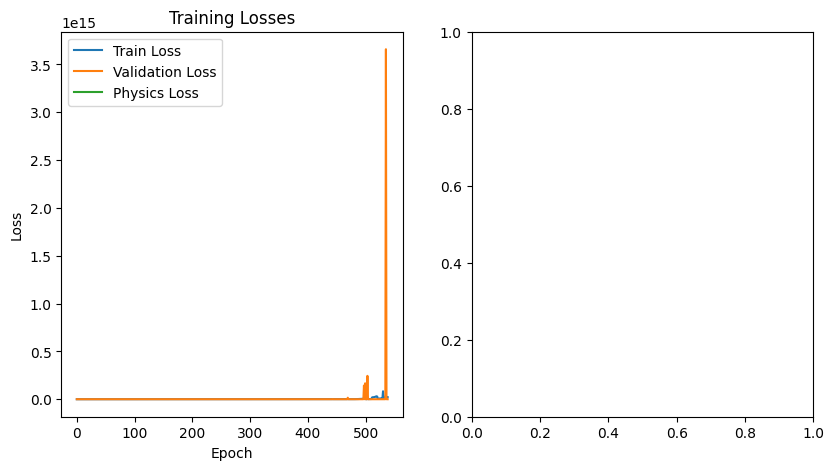

In [11]:

#def main():
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Determine device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Generate synthetic data for the heat equation

# Large dataset generation
num_samples = 40000
theta1 = (np.random.rand(num_samples, 1)-0.5)*np.pi*2
theta2 = (np.random.rand(num_samples, 1)-0.5)*np.pi*2
theta1dot = (np.random.rand(num_samples, 1)-0.5)*np.pi*4
theta2dot = (np.random.rand(num_samples, 1)-0.5)*np.pi*4
time = np.random.rand(num_samples, 1)*5
observation_weights=torch.ones(num_samples,1)
#weighings=torch.arange(0,num_samples).reshape(num_samples,1)
weighings=torch.arange(0,num_samples,dtype=torch.int32).reshape(num_samples,1)
# Train-test split
theta1_train,theta1_test,theta2_train,theta2_test,theta1dot_train,theta1dot_test,theta2dot_train,theta2dot_test,time_train,time_test,weighings_train,weighings_test=train_test_split(
    theta1,theta2,theta1dot,theta2dot,time,weighings,test_size=0.05,random_state=42)


# Convert to PyTorch tensors


theta1_train = torch.FloatTensor(theta1_train)
theta2_train = torch.FloatTensor(theta2_train)
theta1dot_train = torch.FloatTensor(theta1dot_train)
theta2dot_train = torch.FloatTensor(theta2dot_train)
time_train = torch.FloatTensor(time_train)

weighing_train=torch.IntTensor(weighings_train)#weights for the points in the domain

theta1_test = torch.FloatTensor(theta1_test)
theta2_test = torch.FloatTensor(theta2_test)
theta1dot_test = torch.FloatTensor(theta1dot_test)
theta2dot_test = torch.FloatTensor(theta2dot_test)
time_test = torch.FloatTensor(time_test)
#weighings_test=torch.FloatTensor(weighings_test)
weighitngs_test=torch.IntTensor(weighings_test)





# Create DataLoaders
batch_size = 4000#256#128
train_dataset = TensorDataset(theta1_train, theta2_train,theta1dot_train,theta2dot_train, time_train,weighings_train)
val_dataset = TensorDataset(theta1_test, theta2_test,theta1dot_test,theta2dot_test, time_test,weighings_test)



train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Define PINN architecture
layers = [5,48,48,48,48,48, 4]
model = PINN(layers)

# Train PINN
trained_model, history = train_pinn(
    model,
    train_loader,
    val_loader,
    device
)

# Move model to CPU for visualization
trained_model = trained_model.cpu()

# Visualization
plt.figure(figsize=(15, 5))

# Loss history
plt.subplot(1, 3, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
#plt.plot(history['physics_loss'], label='Physics Loss')
plt.title('Training Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Prediction at t=0
plt.subplot(1, 3, 2)
theta_1 = torch.linspace(-np.pi/2, np.pi/2, 100).reshape(-1, 1)
theta_2 = torch.linspace(-np.pi/2, np.pi/2, 100).reshape(-1, 1)

t_test = torch.zeros_like(theta_2)

with torch.no_grad():
    theta1_pred,theta2_pred = trained_model(theta_1,theta_2, t_test)

#u_exact = torch.FloatTensor(exact_solution(x_test.numpy(), t_test.numpy())).reshape(-1, 1)

#plt.scatter(theta_1.numpy(), theta_2.numpy(), label='Training Data', alpha=0.7)

plt.plot(theta_1.numpy(), theta1_pred.numpy(), 'r', label='PINN Predictiontheta1')
plt.plot(theta_2.numpy(), theta2_pred.numpy(), 'r', label='PINN Prediction theta2')

plt.title('PINN Approximation at t=0')
plt.xlabel('theta0')
plt.ylabel('theta at time 0')
plt.legend()
"""
# Prediction at different time points
plt.subplot(1, 3, 3)
t_comparison = [0, 0.5, 1.0]
for t_val in t_comparison:
    t_test = torch.full_like(x_test, t_val)
    with torch.no_grad():
        u_pred = trained_model(x_test, t_test)
    u_exact = torch.FloatTensor(exact_solution(x_test.numpy(), t_test.numpy())).reshape(-1, 1)

    plt.plot(x_test.numpy(), u_pred.numpy(), label=f't={t_val}')
    plt.plot(x_test.numpy(), u_exact.numpy(), '--', label=f'Exact t={t_val}')

plt.title('PINN Predictions at Different Times')
plt.xlabel('x')
plt.ylabel('u(x, t)')
plt.legend()"""

plt.tight_layout()
plt.show()
#return(trained_model)
##if __name__ == '__main__':
#    main()

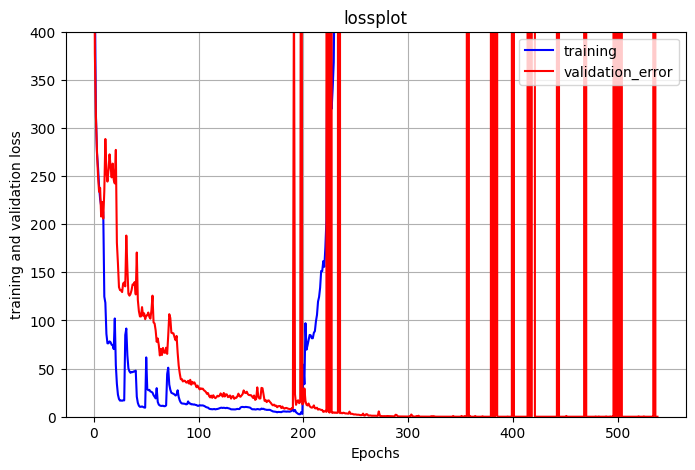

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1.005183435154322e-06


In [49]:
# Create the plot
fig=plt.figure(figsize=(8, 5))
plt.plot(history['train_loss'],label='training', color='blue')
plt.plot(history['val_loss'], label='validation_error', color='red')

plt.xlabel('Epochs')
plt.ylabel('training and validation loss')
plt.title('lossplot')
plt.legend()

# Set x-axis limit
plt.ylim(0, 400)

# Show the plot
plt.grid(True)
plt.show()

fig.savefig("lossplot.png",bbox_inches='tight',format = "png")
#files.download('lossplot.png')
print(np.min(history['val_loss']))

In [26]:
trained_model.eval()


In [32]:
PATH="MULTIPENDULUM.pt"
torch.save(trained_model, PATH)
#files.download(PATH)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

11.356805796678172
196
2.5492102541039086
538
1.005183435154322e-06


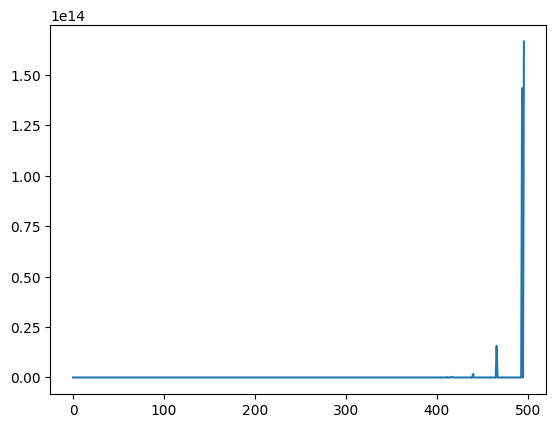

In [14]:
plt.xlim=70

plt.plot((history['val_loss'])[3:500], label='Train Loss')
plt.show
print(history['train_loss'][99])
print(np.argmin(history['train_loss']))
print(np.min(history['train_loss']))

print(np.argmin(history['val_loss']))
print(np.min(history['val_loss']))

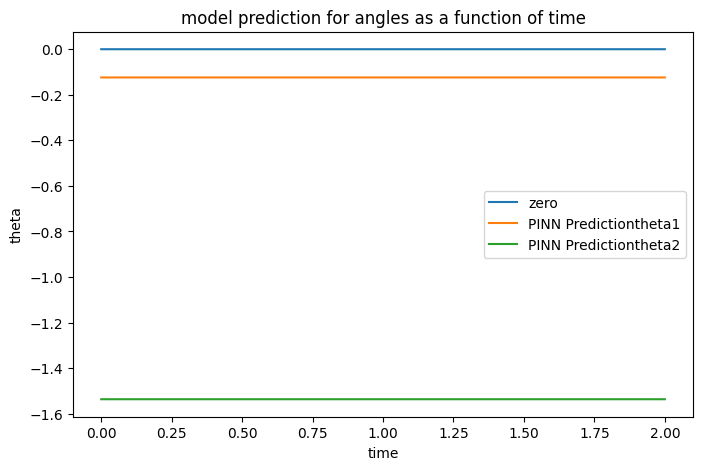

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [48]:
import matplotlib.pyplot as plt
import matplotlib

from matplotlib.animation import FuncAnimation

# Function to compute positions from angles
def double_pendulum_positions(theta1, theta2, l1=1.0, l2=1.0):
    """
    Calculate the positions of a double pendulum's bobs.
    :param theta1: Tensor of angles for the first arm (radians).
    :param theta2: Tensor of angles for the second arm (radians).
    :param l1: Length of the first arm.
    :param l2: Length of the second arm.
    :return: (x1, y1, x2, y2) positions of the pendulum bobs.
    """
    x1 = l1 * torch.sin(theta1)
    y1 = -l1 * torch.cos(theta1)
    x2 = x1 + l2 * torch.sin(theta2)
    y2 = y1 - l2 * torch.cos(theta2)
    return x1.detach().numpy(), y1.detach().numpy(), x2.detach().numpy(), y2.detach().numpy()

# Example input data
#theta1 = torch.linspace(0, 2 * torch.pi, 100)  # Example: varying angle for first arm
#theta2 = torch.linspace(0, 4 * torch.pi, 100)  # Example: varying angle for second arm

seconds=2
time_table = torch.linspace(0, seconds, 10000).reshape(-1, 1)  # Time corresponding to each angle


resultat= trained_model(torch.ones_like(time_table)*np.pi/2,torch.ones_like(time_table)*np.pi/2,torch.ones_like(time_table)*0.001,torch.ones_like(time_table)*0.001,time_table)
theta1_pred = resultat[:, 0:1]  # Predicted theta1
theta2_pred = resultat[:, 1:2]  # Predicted theta2

# Calculate positions
x1, y1, x2, y2 = double_pendulum_positions(theta1_pred, theta2_pred)




#plt.plot(time_table.detach().numpy(),y1.detach().numpy())
#plt.plot(time_table.detach().numpy(),y2.detach().numpy())
#plt.plot(time_table.detach().numpy(),x1.detach().numpy())
#plt.plot(time_table.detach().numpy(),x2.detach().numpy())
fig=plt.figure(figsize=(8, 5))


plt.plot(time_table.detach(),(torch.zeros_like(time_table)).detach().numpy(),label="zero")
plt.plot(time_table.detach(),theta1_pred.detach().numpy(), label='PINN Predictiontheta1')
plt.plot(time_table.detach(),theta2_pred.detach().numpy(), label='PINN Predictiontheta2')
plt.xlabel('time')
plt.ylabel('theta')
plt.title('model prediction for angles as a function of time')
plt.legend()
plt.show()
#print("\n",theta1_pred.detach().numpy(),"\n",theta2_pred.detach().numpy())
#plt.savefig('model_prediction_angles_as_a_function_of_time.png')
fig.savefig("model_prediction_angles_as_a_function_of_time_final.png",bbox_inches='tight',format = "png")
#files.download('model_prediction_angles_as_a_function_of_time_final.png')




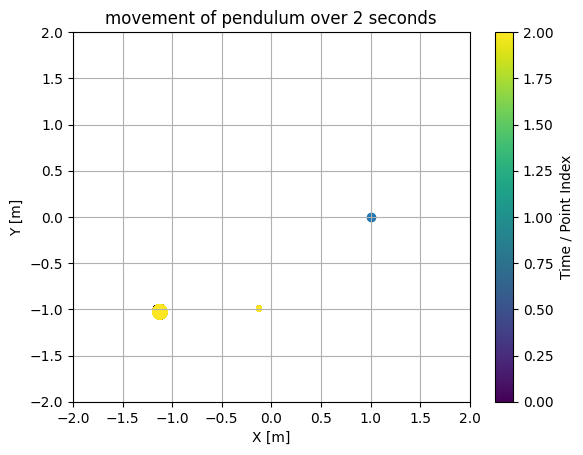

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Sample list of points (x, y)
points = np.hstack((x1,y1))
points2 = np.hstack((x2,y2))

#print(points)
# Normalize the index to create a color gradient (based on the number of points)
num_points = len(points)
norm = plt.Normalize(0, seconds)  # Normalizing based on point index
cmap = plt.get_cmap("viridis")  # You can change the colormap (e.g., 'plasma', 'inferno')

# Plot the points with the color gradient
fig, ax = plt.subplots()
ax.grid()
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
sc = ax.scatter(points[:, 0], points[:, 1], c=np.linspace(0,seconds,num_points), cmap=cmap, norm=norm, s=10)
sc2 = ax.scatter(points2[:, 0], points2[:, 1], c=np.linspace(0,seconds,num_points), cmap=cmap, norm=norm, s=100)
initial=double_pendulum_positions((torch.ones_like(time_table)*np.pi/2)[0],(torch.ones_like(time_table)*np.pi/2)[0])
sc3=ax.scatter(initial[0],initial[1], label='initial position')

# Add a color bar to indicate the time/gradient scale
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Time / Point Index')
#cbar = plt.colorbar(sc2, ax=ax)
#cbar.set_label('Time / Point Index')
# Optional: Labeling axes
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_title('movement of pendulum over 2 seconds')

plt.show()

fig.savefig("movement_of_pendulum_over_2_seconds.png",bbox_inches='tight',format = "png")
files.download('movement_of_pendulum_over_2_seconds.png')